# 영화 장르별 편향성 분석 (WEAT)

이 노트북은 Word Embedding Association Test(WEAT)를 사용하여 영화 장르 간의 편향성을 분석합니다.

## 실행 전 준비사항
1. Google Drive를 마운트하세요
2. `/content/drive/MyDrive/TorchData/synopsis/` 경로에 다음 파일들이 있어야 합니다:
   - synopsis.txt (전체 시놉시스)
   - synopsis_art.txt (예술영화)
   - synopsis_genre.txt (일반영화)
   - 21개 장르별 txt 파일들

## STEP 0: 환경 설정 및 라이브러리 설치

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# 필요한 라이브러리 설치
!pip install konlpy
!pip install gensim==4.3.2
!pip install scipy==1.12.0 numpy==1.26.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 105.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.3/23.3 MB 75.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gensim: filename=gensim-4.3.2-cp312-cp312-linux_x86_64.whl size=26332391 sha256=b81ef5ff8bde34067584deaea9dda829308d5620994efd3338689addfcedda5b
  Stored in directory: /root/.cache/pip/wheels/50/c0/ac/7bb08954bc59d390c848b480a3fc5eec68c14bc77bf334d624
Successfully built gensim
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.4 MB/s eta 0:00:00
  Using cached numpy-1.26.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.8/37.8 MB 23.5 MB/s eta 0:00:00
Using cached numpy-1.26.2-cp312-cp312-manylinux_2_17_x86_64.ma

In [1]:
# 한글 폰트 설치 (시각화용)
!apt-get update -qq
!apt-get install -qq fonts-nanum

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [2]:
# 필요한 라이브러리 임포트
import os
import numpy as np
from numpy import dot
from numpy.linalg import norm
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from konlpy.tag import Okt
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

# 한글 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False
sns.set(font='NanumGothic')

print("✅ 라이브러리 임포트 완료")

✅ 라이브러리 임포트 완료


In [11]:
# 파일 경로 설정
data_dir = '/content/drive/MyDrive/TorchData/synopsis'
file_path = os.path.join(data_dir, 'synopsis.txt')

# 예술영화 vs 일반영화 파일명 (실제 파일명에 맞게 수정하세요)
art_txt = 'synopsis_art.txt'  # 예술영화
gen_txt = 'synopsis_gen.txt'  # 일반영화

# 장르별 파일 목록
genre_txt = [
    'synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt',
    'synopsis_horror.txt', 'synopsis_etc.txt', 'synopsis_documentary.txt',
    'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt',
    'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt',
    'synopsis_western.txt', 'synopsis_adult.txt', 'synopsis_thriller.txt',
    'synopsis_animation.txt', 'synopsis_action.txt', 'synopsis_adventure.txt',
    'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt'
]

genre_name = [
    'SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마',
    '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
    '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁',
    '코미디', '판타지'
]

print(f"✅ 파일 경로 설정 완료: {data_dir}")
print(f"총 {len(genre_txt)}개 장르 분석 예정")

✅ 파일 경로 설정 완료: /content/drive/MyDrive/TorchData/synopsis
총 21개 장르 분석 예정


## STEP 1: 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

In [5]:
# 데이터 샘플 확인
print("📖 데이터 샘플 (처음 20줄):")
print("=" * 80)
with open(file_path, 'r', encoding='utf-8') as f:
    for i in range(20):
        line = f.readline()
        if not line:
            break
        print(line, end='')
print("\n" + "=" * 80)

📖 데이터 샘플 (처음 20줄):
사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 

In [6]:
# 명사 추출 (약 15분 소요)
print("🔄 명사 추출 중... (약 15분 소요)")

okt = Okt()
tokenized = []

with open(file_path, 'r', encoding='utf-8') as file:
    line_count = 0
    while True:
        line = file.readline()
        if not line:
            break

        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:
                res.append(w[0])
        tokenized.append(res)

        line_count += 1
        if line_count % 1000 == 0:
            print(f"  처리 완료: {line_count}줄")

print(f"\n✅ 명사 추출 완료! 총 {len(tokenized)}개 문장 처리")
print(f"예시: {tokenized[0][:10]}...")

🔄 명사 추출 중... (약 15분 소요)
  처리 완료: 1000줄
  처리 완료: 2000줄
  처리 완료: 3000줄
  처리 완료: 4000줄
  처리 완료: 5000줄
  처리 완료: 6000줄
  처리 완료: 7000줄
  처리 완료: 8000줄
  처리 완료: 9000줄
  처리 완료: 10000줄
  처리 완료: 11000줄
  처리 완료: 12000줄
  처리 완료: 13000줄
  처리 완료: 14000줄
  처리 완료: 15000줄
  처리 완료: 16000줄
  처리 완료: 17000줄
  처리 완료: 18000줄
  처리 완료: 19000줄
  처리 완료: 20000줄
  처리 완료: 21000줄
  처리 완료: 22000줄
  처리 완료: 23000줄
  처리 완료: 24000줄
  처리 완료: 25000줄
  처리 완료: 26000줄
  처리 완료: 27000줄
  처리 완료: 28000줄
  처리 완료: 29000줄
  처리 완료: 30000줄
  처리 완료: 31000줄
  처리 완료: 32000줄
  처리 완료: 33000줄
  처리 완료: 34000줄
  처리 완료: 35000줄
  처리 완료: 36000줄
  처리 완료: 37000줄
  처리 완료: 38000줄
  처리 완료: 39000줄
  처리 완료: 40000줄
  처리 완료: 41000줄
  처리 완료: 42000줄
  처리 완료: 43000줄
  처리 완료: 44000줄
  처리 완료: 45000줄
  처리 완료: 46000줄
  처리 완료: 47000줄
  처리 완료: 48000줄
  처리 완료: 49000줄
  처리 완료: 50000줄
  처리 완료: 51000줄
  처리 완료: 52000줄
  처리 완료: 53000줄
  처리 완료: 54000줄
  처리 완료: 55000줄
  처리 완료: 56000줄
  처리 완료: 57000줄
  처리 완료: 58000줄
  처리 완료: 59000줄
  처리 완료: 60000줄
  처리 완료: 61000줄
  처리 완료: 

## STEP 2: 추출된 결과로 Embedding Model 만들기 (Word2Vec)

In [7]:
# Word2Vec 모델 학습
print("🔄 Word2Vec 모델 학습 중...")

model = Word2Vec(
    tokenized,
    vector_size=100,  # 벡터 차원
    window=5,         # 윈도우 크기
    min_count=3,      # 최소 출현 빈도
    sg=0              # CBOW 방식
)

print("✅ Word2Vec 모델 학습 완료!")
print(f"총 어휘 수: {len(model.wv)}개")
print("\n'영화'와 유사한 단어들:")
print(model.wv.most_similar(positive=['영화']))

🔄 Word2Vec 모델 학습 중...
✅ Word2Vec 모델 학습 완료!
총 어휘 수: 24320개

'영화'와 유사한 단어들:
[('작품', 0.8885435461997986), ('다큐멘터리', 0.8396621942520142), ('드라마', 0.8146717548370361), ('영화로', 0.7838200926780701), ('형식', 0.774520993232727), ('주제', 0.7727822661399841), ('코미디', 0.771070659160614), ('스토리', 0.7606037259101868), ('감동', 0.7487404942512512), ('인터뷰', 0.7416160106658936)]


In [8]:
# 다른 단어들도 테스트
test_words = ['사랑', '연극', '감독', '배우']

for word in test_words:
    if word in model.wv:
        print(f"\n'{word}'와 유사한 단어들:")
        print(model.wv.most_similar(positive=[word]))
    else:
        print(f"\n'{word}'는 모델에 없습니다.")


'사랑'와 유사한 단어들:
[('행복', 0.711199164390564), ('만남', 0.7007990479469299), ('진심', 0.6826854348182678), ('첫사랑', 0.6826401352882385), ('이별', 0.6790666580200195), ('연애', 0.6746405959129333), ('가슴', 0.6705927848815918), ('우정', 0.6690642237663269), ('아픔', 0.6615024209022522), ('만인', 0.6576357483863831)]

'연극'와 유사한 단어들:
[('영화감독', 0.9055184721946716), ('시나리오', 0.8875988125801086), ('배우', 0.8820183277130127), ('영감', 0.8775871396064758), ('데뷔', 0.8767450451850891), ('각색', 0.8667953610420227), ('실황', 0.8610934019088745), ('캐스팅', 0.859537661075592), ('출연', 0.8591644763946533), ('오노레', 0.8552663922309875)]

'감독'와 유사한 단어들:
[('소설', 0.8065935969352722), ('영화감독', 0.8043704032897949), ('시나리오', 0.7999647855758667), ('작품', 0.7989403009414673), ('데뷔', 0.7922073006629944), ('오노레', 0.7906743884086609), ('영화로', 0.7872881889343262), ('다큐멘터리', 0.7837433218955994), ('원작', 0.7831702828407288), ('김호정', 0.781437337398529)]

'배우'와 유사한 단어들:
[('여배우', 0.9227222800254822), ('출연', 0.9129312038421631), ('시나리오', 0.9088492989

## STEP 3: Target, Attribute 단어 셋 만들기

In [9]:
# 파일에서 명사 토큰 추출하는 함수
def read_token(file_name):
    okt = Okt()
    result = []
    file_full_path = os.path.join(data_dir, file_name)

    print(f"  📖 {file_name} 파일을 읽고 있습니다...")

    with open(file_full_path, 'r', encoding='utf-8') as fread:
        while True:
            line = fread.readline()
            if not line:
                break
            tokenlist = okt.pos(line, stem=True, norm=True)
            for word in tokenlist:
                if word[1] in ["Noun"]:
                    result.append(word[0])

    return ' '.join(result)

print("✅ 토큰 추출 함수 정의 완료")

✅ 토큰 추출 함수 정의 완료


In [12]:
# 예술영화 vs 일반영화 토큰 추출 (각 파일당 약 5분 소요)
print("🔄 예술영화 & 일반영화 토큰 추출 중... (약 10분 소요)")

art = read_token(art_txt)
gen = read_token(gen_txt)

print("\n✅ 토큰 추출 완료!")
print(f"예술영화 토큰 수: {len(art.split())}개")
print(f"일반영화 토큰 수: {len(gen.split())}개")

🔄 예술영화 & 일반영화 토큰 추출 중... (약 10분 소요)
  📖 synopsis_art.txt 파일을 읽고 있습니다...
  📖 synopsis_gen.txt 파일을 읽고 있습니다...

✅ 토큰 추출 완료!
예술영화 토큰 수: 208471개
일반영화 토큰 수: 1008358개


In [13]:
# TF-IDF로 중요 단어 추출
print("🔄 TF-IDF 계산 중...")

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(f"✅ TF-IDF 행렬 생성 완료: {X.shape}")
print(f"총 어휘 수: {len(vectorizer.vocabulary_)}개")

🔄 TF-IDF 계산 중...
✅ TF-IDF 행렬 생성 완료: (2, 41082)
총 어휘 수: 41082개


In [14]:
# TF-IDF 기준 상위 단어 추출
m1 = X[0].tocoo()  # 예술영화
m2 = X[1].tocoo()  # 일반영화

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)
w2.sort(key=lambda x: x[1], reverse=True)

print("🎬 예술영화를 대표하는 단어들 (상위 100개):")
for i in range(100):
    print(vectorizer.get_feature_names_out()[w1[i][0]], end=', ')

print('\n\n🎥 일반영화를 대표하는 단어들 (상위 100개):')
for i in range(100):
    print(vectorizer.get_feature_names_out()[w2[i][0]], end=', ')

🎬 예술영화를 대표하는 단어들 (상위 100개):
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 시간, 다시, 아들, 소녀, 아내, 다른, 영화제, 사이, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 아빠, 생활, 통해, 모습, 기억, 죽음, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 결혼, 사고, 전쟁, 위기, 때문, 이제, 최고, 이자, 과거, 일상, 경찰, 간다, 상황, 미국, 운명, 결심, 관계, 현실, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 만난, 감정, 처음, 국제, 누구, 살인, 충격, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

🎥 일반영화를 대표하는 단어들 (상위 100개):
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 의도, 동생, 하루, 위기, 계획, 정체, 한국, 

In [15]:
# Target 단어 추출 (예술영화만의 특징 단어 vs 일반영화만의 특징 단어)
n = 15  # 추출할 단어 개수

w1_ = [vectorizer.get_feature_names_out()[w1[i][0]] for i in range(100)]
w2_ = [vectorizer.get_feature_names_out()[w2[i][0]] for i in range(100)]

# 예술영화에만 있는 단어 (Word2Vec 모델에도 있는 것만)
target_art = []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv):
        target_art.append(w1_[i])
    if len(target_art) == n:
        break

# 일반영화에만 있는 단어 (Word2Vec 모델에도 있는 것만)
target_gen = []
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv):
        target_gen.append(w2_[i])
    if len(target_gen) == n:
        break

print(f"\n✅ Target 단어 추출 완료!")
print(f"\n🎬 예술영화 Target 단어 ({len(target_art)}개):")
print(target_art)
print(f"\n🎥 일반영화 Target 단어 ({len(target_gen)}개):")
print(target_gen)


✅ Target 단어 추출 완료!

🎬 예술영화 Target 단어 (15개):
['아빠', '음악', '운명', '결심', '지금', '여인', '이름', '이후', '준비', '만난', '감정', '처음', '누구', '충격', '그린']

🎥 일반영화 Target 단어 (15개):
['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


In [16]:
# 장르별 Attribute 단어 추출
print("🔄 장르별 특징 단어 추출 중... (시간이 꽤 걸립니다)")

# 장르별 토큰 추출
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

print("\n✅ 장르별 토큰 추출 완료!")

🔄 장르별 특징 단어 추출 중... (시간이 꽤 걸립니다)
  📖 synopsis_SF.txt 파일을 읽고 있습니다...
  📖 synopsis_family.txt 파일을 읽고 있습니다...
  📖 synopsis_show.txt 파일을 읽고 있습니다...
  📖 synopsis_horror.txt 파일을 읽고 있습니다...
  📖 synopsis_etc.txt 파일을 읽고 있습니다...
  📖 synopsis_documentary.txt 파일을 읽고 있습니다...
  📖 synopsis_drama.txt 파일을 읽고 있습니다...
  📖 synopsis_romance.txt 파일을 읽고 있습니다...
  📖 synopsis_musical.txt 파일을 읽고 있습니다...
  📖 synopsis_mystery.txt 파일을 읽고 있습니다...
  📖 synopsis_crime.txt 파일을 읽고 있습니다...
  📖 synopsis_historical.txt 파일을 읽고 있습니다...
  📖 synopsis_western.txt 파일을 읽고 있습니다...
  📖 synopsis_adult.txt 파일을 읽고 있습니다...
  📖 synopsis_thriller.txt 파일을 읽고 있습니다...
  📖 synopsis_animation.txt 파일을 읽고 있습니다...
  📖 synopsis_action.txt 파일을 읽고 있습니다...
  📖 synopsis_adventure.txt 파일을 읽고 있습니다...
  📖 synopsis_war.txt 파일을 읽고 있습니다...
  📖 synopsis_comedy.txt 파일을 읽고 있습니다...
  📖 synopsis_fantasy.txt 파일을 읽고 있습니다...

✅ 장르별 토큰 추출 완료!


In [17]:
# 장르별 TF-IDF 계산
print("🔄 장르별 TF-IDF 계산 중...")

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(f"✅ TF-IDF 행렬 생성 완료: {X.shape}")

🔄 장르별 TF-IDF 계산 중...
✅ TF-IDF 행렬 생성 완료: (21, 42191)


In [18]:
def extract_unique_keywords_relative(X, vectorizer, model, genre_name, n=15):
    """
    각 장르에서 다른 장르 대비 상대적으로 중요한 단어 선택
    (현재 장르 TF-IDF) - (다른 장르들 평균 TF-IDF)
    """
    import numpy as np

    X_dense = X.toarray()
    attributes = []

    print("🔄 상대적 중요도 방식으로 고유 키워드 추출 중...\n")

    for i in range(len(genre_name)):
        print(f"{genre_name[i]:12s}: ", end='')

        # 현재 장르의 TF-IDF
        current_tfidf = X_dense[i]

        # 다른 장르들의 평균 TF-IDF
        other_indices = [j for j in range(len(genre_name)) if j != i]
        other_mean = np.mean(X_dense[other_indices], axis=0)

        # 상대적 중요도 = 현재 - 다른 장르 평균
        relative_importance = current_tfidf - other_mean

        # 상대적 중요도가 높은 순서로 정렬
        sorted_indices = np.argsort(relative_importance)[::-1]

        attr = []
        for idx in sorted_indices:
            word = vectorizer.get_feature_names_out()[idx]
            if word in model.wv and relative_importance[idx] > 0:
                attr.append(word)
                print(word, end=', ')
                if len(attr) >= n:
                    break

        attributes.append(attr)
        print(f" [{len(attr)}개]")

    print("\n✅ 장르별 상대적 고유 키워드 추출 완료!")
    return attributes

# 함수 실행
attributes = extract_unique_keywords_relative(X, vectorizer, model, genre_name, n=15)


🔄 상대적 중요도 방식으로 고유 키워드 추출 중...

SF          : 지구, 인류, 인간, 우주, 미래, 로봇, 박사, 우주선, 외계, 행성, 위해, 세계, 스타크, 리플리, 시스템,  [15개]
가족          : 아빠, 엄마, 아주르, 가족, 낙타, 씨제이, 동구, 할머니, 아버지, 영화제, 슈이트, 아들, 학교, 마갈, 펠리칸,  [15개]
공연          : 오페라, 토스카, 실황, 올레, 사랑, 카바, 오텔로, 리골레토, 공연, 베르디, 프레, 백작, 비바, 카르피, 콘서트,  [15개]
공포(호러)      : 공포, 친구, 사람, 사건, 악령, 발견, 죽음, 좀비, 시작, 저주, 악몽, 살해, 일행, 마을, 살인,  [15개]
기타          : 영화제, 국제, 서울, 단편, 뉴미디어, 페스티벌, 이야기, 영화, 독립, 아시아나, 연출, 이미지, 상영작, 지하철, 부산,  [15개]
다큐멘터리       : 영화제, 다큐, 다큐멘터리, 영화, 국제, 감독, 우리, 대한, 이야기, 서울, 여성, 한국, 통해, 환경, 세계,  [15개]
드라마         : 영화제, 영화, 사랑, 그녀, 자신, 국제, 단편, 엄마, 사람, 남자, 이야기, 여자, 서울, 마음, 아버지,  [15개]
멜로로맨스       : 그녀, 사랑, 남편, 섹스, 여자, 남자, 마음, 결혼, 부부, 서로, 관계, 친구, 연애, 유혹, 애인,  [15개]
뮤지컬         : 뮤지컬, 에스메랄다, 충무로, 음악, 모차르트, 니웨, 토스카, 카바, 바흐, 페뷔스, 프롤, 모도, 카르피, 샤오캉, 제루샤,  [15개]
미스터리        : 사건, 그녀, 진실, 민혁, 사고, 시작, 죽음, 기억, 미스터리, 현우, 살인, 방독면, 발견, 의문, 형사,  [15개]
범죄          : 사건, 경찰, 범죄, 조직, 살인, 마약, 형사, 한길수, 수사, 살해, 은행, 범인, 계획, 위해, 마피아,  [15개]
사극          : 조선, 신기전, 

## STEP 4: WEAT Score 계산 및 시각화

In [19]:
# WEAT 계산 함수 정의
def cos_sim(i, j):
    """코사인 유사도 계산"""
    return dot(i, j.T) / (norm(i) * norm(j))

def s(w, A, B):
    """단어 w와 두 속성 집합 A, B 간의 연관성 차이 계산"""
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B

def weat_score(X, Y, A, B):
    """
    WEAT (Word Embedding Association Test) 점수 계산
    X, Y: Target 단어 집합
    A, B: Attribute 단어 집합
    """
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)

    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))

    return (mean_X - mean_Y) / std_dev

print("✅ WEAT 계산 함수 정의 완료")

✅ WEAT 계산 함수 정의 완료


In [20]:
# Target 단어들의 벡터 준비
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

print(f"✅ Target 벡터 준비 완료")
print(f"예술영화 Target: {X.shape}")
print(f"일반영화 Target: {Y.shape}")

✅ Target 벡터 준비 완료
예술영화 Target: (15, 100)
일반영화 Target: (15, 100)


In [21]:
# 장르 간 WEAT 점수 계산
print("🔄 장르 쌍별 WEAT 점수 계산 중...\n")

matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

total_pairs = sum(range(len(genre_name)))
completed = 0

for i in range(len(genre_name) - 1):
    for j in range(i + 1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])

        matrix[i][j] = weat_score(X, Y, A, B)

        completed += 1
        if completed % 20 == 0:
            print(f"  진행률: {completed}/{total_pairs} ({100*completed/total_pairs:.1f}%)")

print(f"\n✅ WEAT 점수 계산 완료! (총 {total_pairs}개 쌍)")

🔄 장르 쌍별 WEAT 점수 계산 중...

  진행률: 20/210 (9.5%)
  진행률: 40/210 (19.0%)
  진행률: 60/210 (28.6%)
  진행률: 80/210 (38.1%)
  진행률: 100/210 (47.6%)
  진행률: 120/210 (57.1%)
  진행률: 140/210 (66.7%)
  진행률: 160/210 (76.2%)
  진행률: 180/210 (85.7%)
  진행률: 200/210 (95.2%)

✅ WEAT 점수 계산 완료! (총 210개 쌍)


In [23]:
# 결과 확인 (상위 10개)
print("\n📊 WEAT 점수 샘플 (상위 10개):")
print("=" * 60)
print(f"{'장르1':12s} {'장르2':12s} {'WEAT 점수':>12s}")
print("=" * 60)

count = 0
for i in range(len(genre_name) - 1):
    for j in range(i + 1, len(genre_name)):
        print(f"{genre_name[i]:12s} {genre_name[j]:12s} {matrix[i][j]:12.4f}")
        count += 1
        if count >= 10:
            break
    if count >= 10:
        break

print("...")


📊 WEAT 점수 샘플 (상위 10개):
장르1          장르2               WEAT 점수
SF           가족                -0.6969
SF           공연                -0.3201
SF           공포(호러)            -0.7169
SF           기타                 0.5318
SF           다큐멘터리              0.4540
SF           드라마               -0.4247
SF           멜로로맨스             -0.7580
SF           뮤지컬                0.1061
SF           미스터리              -0.6823
SF           범죄                -0.3059
...


🔄 Heatmap 생성 중...

✅ Heatmap 생성 완료!


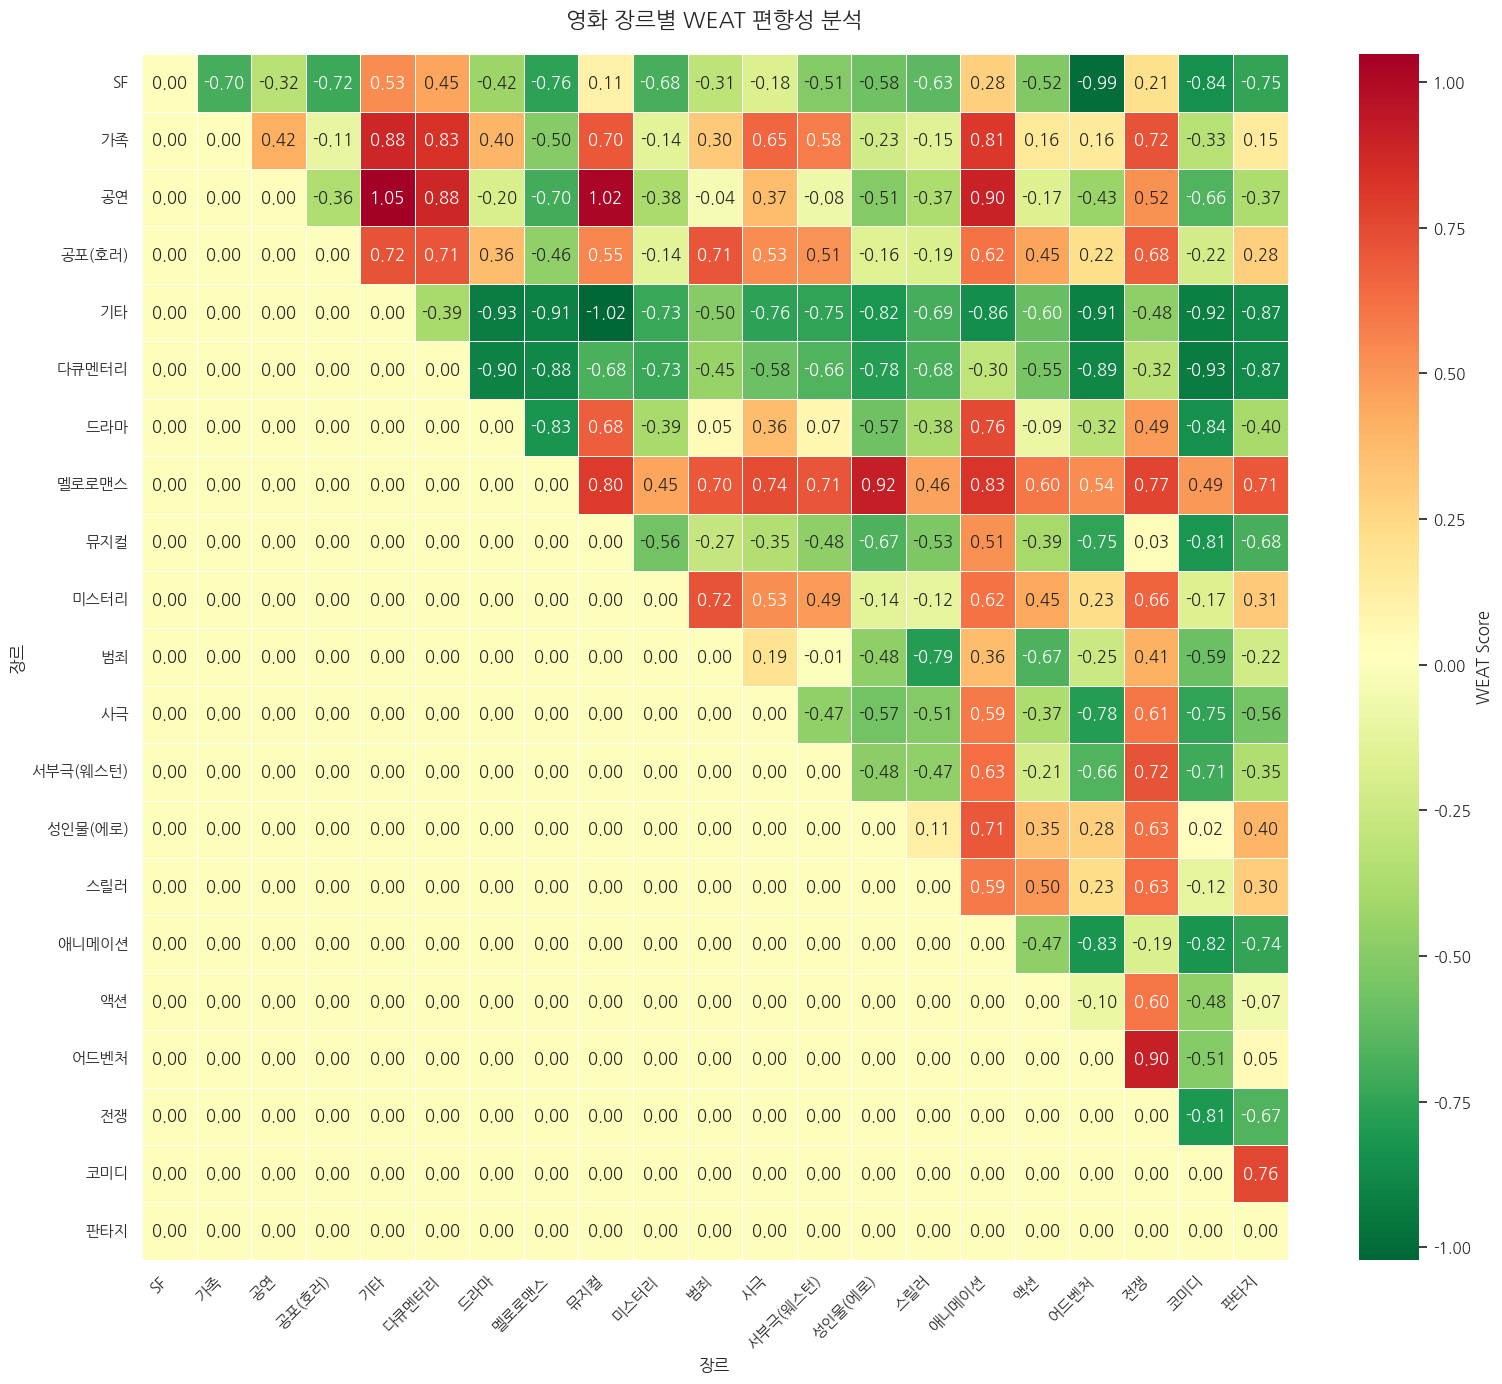

In [24]:
# Heatmap 시각화
print("🔄 Heatmap 생성 중...\n")

plt.figure(figsize=(16, 14))
ax = sns.heatmap(
    matrix,
    xticklabels=genre_name,
    yticklabels=genre_name,
    annot=True,
    fmt='.2f',
    cmap='RdYlGn_r',
    cbar_kws={'label': 'WEAT Score'},
    linewidths=0.5
)

plt.title('영화 장르별 WEAT 편향성 분석', fontsize=16, pad=20)
plt.xlabel('장르', fontsize=12)
plt.ylabel('장르', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

print("✅ Heatmap 생성 완료!")
plt.show()

## 결과 해석 가이드

### WEAT Score 의미
- **양수(+)**: 예술영화가 해당 장르 쌍에서 첫 번째 장르와 더 강하게 연관
- **음수(-)**: 일반영화가 해당 장르 쌍에서 첫 번째 장르와 더 강하게 연관
- **절댓값이 클수록**: 편향이 더 강함

### 주의사항
- TF-IDF는 각 장르를 대표하는 단어를 선정하는 방법으로, 높은 단어일수록 해당 장르를 잘 표현합니다
- WEAT 계산 결과는 어떤 카테고리가 어떤 장르와 더 시각적으로 두드러지게 구성되어 있는지를 나타냅니다
- 편향성이 반드시 문제를 의미하지는 않으며, 장르의 특성을 반영한 것일 수 있습니다

In [26]:
# 추가 분석: 가장 편향성이 강한/약한 장르 쌍 찾기
print("\n📈 추가 분석 결과\n")
print("=" * 70)

# 모든 쌍의 점수 수집
all_scores = []
for i in range(len(genre_name) - 1):
    for j in range(i + 1, len(genre_name)):
        all_scores.append((genre_name[i], genre_name[j], matrix[i][j]))

# 절댓값 기준 정렬
all_scores.sort(key=lambda x: abs(x[2]), reverse=True)

print("\n🔴 편향성이 가장 강한 장르 쌍 (상위 10개):")
for i, (g1, g2, score) in enumerate(all_scores[:10], 1):
    direction = "예술영화" if score > 0 else "일반영화"
    print(f"{i:2d}. {g1:12s} vs {g2:12s}: {score:7.4f} ({direction} 편향)")

print("\n🟢 편향성이 가장 약한 장르 쌍 (하위 10개):")
for i, (g1, g2, score) in enumerate(all_scores[-10:][::-1], 1):
    print(f"{i:2d}. {g1:12s} vs {g2:12s}: {score:7.4f} (균형적)")



📈 추가 분석 결과


🔴 편향성이 가장 강한 장르 쌍 (상위 10개):
 1. 공연           vs 기타          :  1.0477 (예술영화 편향)
 2. 기타           vs 뮤지컬         : -1.0217 (일반영화 편향)
 3. 공연           vs 뮤지컬         :  1.0173 (예술영화 편향)
 4. SF           vs 어드벤처        : -0.9898 (일반영화 편향)
 5. 다큐멘터리        vs 코미디         : -0.9337 (일반영화 편향)
 6. 기타           vs 드라마         : -0.9296 (일반영화 편향)
 7. 기타           vs 코미디         : -0.9210 (일반영화 편향)
 8. 멜로로맨스        vs 성인물(에로)     :  0.9153 (예술영화 편향)
 9. 기타           vs 어드벤처        : -0.9128 (일반영화 편향)
10. 기타           vs 멜로로맨스       : -0.9057 (일반영화 편향)

🟢 편향성이 가장 약한 장르 쌍 (하위 10개):
 1. 범죄           vs 서부극(웨스턴)    : -0.0087 (균형적)
 2. 성인물(에로)      vs 코미디         :  0.0203 (균형적)
 3. 뮤지컬          vs 전쟁          :  0.0305 (균형적)
 4. 공연           vs 범죄          : -0.0370 (균형적)
 5. 드라마          vs 범죄          :  0.0465 (균형적)
 6. 어드벤처         vs 판타지         :  0.0487 (균형적)
 7. 액션           vs 판타지         : -0.0654 (균형적)
 8. 드라마          vs 서부극(웨스턴)    :  0.0744 (균형적)
 9. 공연           vs 서부극(웨

## 완료! 🎉

모든 분석이 완료되었습니다. 결과를 바탕으로 영화 장르 간의 편향성 패턴을 분석해보세요!

### 다음 단계 제안
1. 특정 장르 쌍에 대해 더 깊이 분석하기
2. Attribute 단어를 조정하여 다른 관점에서 분석하기
3. Target 단어(예술영화 vs 일반영화)를 다른 기준으로 정의하기
4. 결과를 논문이나 보고서로 작성하기